# Documento de análisis de métricas

En este documento de Jupyter Notebook vamos a analizar las métricas propuestas en el **Documento de investigación**

Para ello se va a empezar uniendo todos los archivos .json que hay en la carpeta **./JSONS** en un solo .json, tras ello se harán los cálculos correspondientes.

In [1]:
import pandas as pd
import os
import json
import numpy as np

In [2]:
folder="./JSONS"
combinedData=[]
for file in os.listdir(folder):
    if(file.endswith('.json')):
        route=os.path.join(folder,file)
        with open(route,'r')as f:
            jsonfile=json.load(f)
            combinedData.extend(jsonfile['data'])
jsonFile={'data':combinedData}
with open('data_combined.json', 'w') as f:
    json.dump(jsonFile, f)

In [3]:
x = pd.json_normalize(jsonFile['data'])
groupedEvents = x.groupby('eventType')
##for eid, group in groupedEvents:
    ##display(group)
    ##display(eid)

### Los eventos y sus ID:
```C#
//Eventos comunes
 SessionStart = 0
 SessionStop = 1
 GameStart = 2
 GameEnd = 3
 LevelStart = 4
 LevelEnd = 5
 Pause = 6
 Resume = 7
 // Eventos de juego
 Attack = 8
 EnemyReceive = 9
 PlayerReceive = 10
 RoomMove = 11
```


# Métrica 1: Tiempo de finalización de nivel
¿El jugador tarda demasiado tiempo en completar cada uno de los dos niveles?

Media de las duraciones del nivel 1:  90.95006670951844
Mediana de las duraciones del nivel 1:  71.89100003242493
Desviación típica de las duraciones del nivel 1:  58.982521595559646


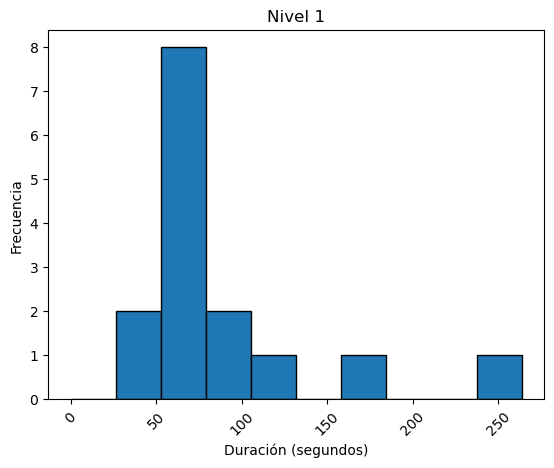

Media de las duraciones del nivel 2:  72.01957140650067
Mediana de las duraciones del nivel 2:  75.79500007629395
Desviación típica de las duraciones del nivel 2:  12.060731050539216


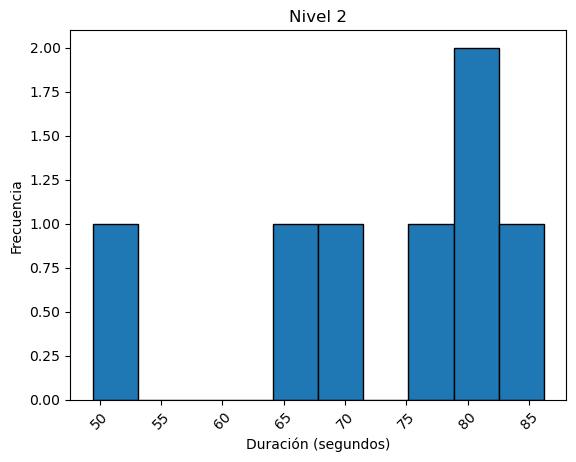

In [4]:
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
startEvent = groupedEvents.get_group(4)
#display(startEvent)
endEvent = groupedEvents.get_group(5)
#display(endEvent)
#Filtrar niveles completados con éxito
endEvent_filtered = endEvent[endEvent['LevelEnd'] == 0]
startEvent_filtered = startEvent[startEvent['Level'].isin(endEvent_filtered['Level']) & startEvent['GameSession'].isin(endEvent_filtered['GameSession'])]
endEvent_filtered = endEvent_filtered.copy()
#nueva columna de eventos end por nivel
endEvent_filtered.loc[:, 'combined'] = endEvent_filtered['Level'].astype(str) + '-' + endEvent_filtered['GameSession'].astype(str)
startEvent = startEvent.copy()
#Nueva columna de eventos start por nivel
startEvent.loc[:, 'combined'] = startEvent['Level'].astype(str) + '-' + startEvent['GameSession'].astype(str)
startEvent_filtered = startEvent[startEvent['combined'].isin(endEvent_filtered['combined'])]
#Borrar cols
del startEvent_filtered['combined']
del endEvent_filtered['combined']

durations = []
for i in range(len(startEvent_filtered)):
    #Timestamps de inicio y fin
    start_time = startEvent_filtered.iloc[i]['timestamp']
    end_time = endEvent_filtered.iloc[i]['timestamp']
    total_pause_duration = 0
    #Comprobar pausas/resumes
    if 6 in groupedEvents.groups and 7 in groupedEvents.groups:
        pauseEvents = groupedEvents.get_group(6)
        resumeEvents = groupedEvents.get_group(7)
        #Filtrar pausas
        pauses_in_range = pauseEvents[(pauseEvents['timestamp'] >= start_time) & (pauseEvents['timestamp'] <= end_time)]
        resumes_in_range = resumeEvents[(resumeEvents['timestamp'] >= start_time) & (resumeEvents['timestamp'] <= end_time)]
        
        #Sumar tiempo pausa
        for j in range(len(pauses_in_range)):
            pause_time = pauses_in_range.iloc[j]['timestamp']
            resume_time = resumes_in_range.iloc[j]['timestamp']
            pause_duration = resume_time - pause_time
            total_pause_duration += pause_duration
            
    a_seconds = start_time / 1000
    b_seconds = end_time / 1000
    total_pause_duration= total_pause_duration / 1000
    #duración
    duration = b_seconds - a_seconds- total_pause_duration
    durations.append(duration)

startEvent_filtered = startEvent_filtered.copy()
#nueva columna de duraciones, más abajo se borra
startEvent_filtered['duration'] = durations

#Separar los eventos por nivel
level1_events = startEvent_filtered[startEvent_filtered['Level'] == 1]
level2_events = startEvent_filtered[startEvent_filtered['Level'] == 2]

#Media de las duraciones para cada nivel
mean_duration_level1 = level1_events['duration'].mean()
mean_duration_level2 = level2_events['duration'].mean()
#Mediana de las duraciones de cada nivel
median_duration_level1 = level1_events['duration'].median()
median_duration_level2 = level2_events['duration'].median()
max_duration_level1 = level1_events['duration'].max()
max_duration_level2 = level2_events['duration'].max()
#Desv. típicas
std_duration_level1 = level1_events['duration'].std()
std_duration_level2 = level2_events['duration'].std()

maxi = max(max_duration_level1, max_duration_level2)
print("Media de las duraciones del nivel 1: ", mean_duration_level1)
print("Mediana de las duraciones del nivel 1: ", median_duration_level1)
print("Desviación típica de las duraciones del nivel 1: ", std_duration_level1)
#Histograma Nivel 1
plt.hist(level1_events['duration'], bins=10, range=(0,maxi), edgecolor='black')
plt.title('Nivel 1')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
#rotar
plt.xticks(rotation=45)
plt.show()
print("Media de las duraciones del nivel 2: ", mean_duration_level2)
print("Mediana de las duraciones del nivel 2: ", median_duration_level2)
print("Desviación típica de las duraciones del nivel 2: ", std_duration_level2)
#Histograma Nivel 2
plt.hist(level2_events['duration'], bins=10, edgecolor='black')
plt.title('Nivel 2')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
#rotar
plt.xticks(rotation=45)
plt.show()
del startEvent_filtered['duration']

# Métrica 2: Cantidad de movimientos por nivel
¿El jugador usa demasiados movimientos de salas en cada uno de los dos niveles?

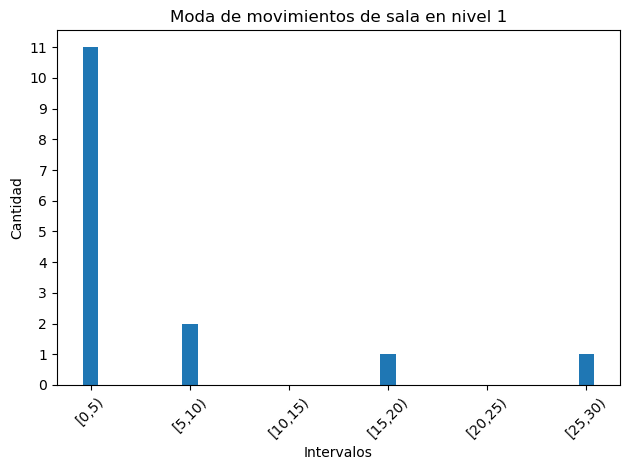

En el nivel 1 la cantidad más repetida/s de movimientos necesarios es/son la/s siguiente/s
[ 0 , 5 )
Repitiendose un total de  11  veces


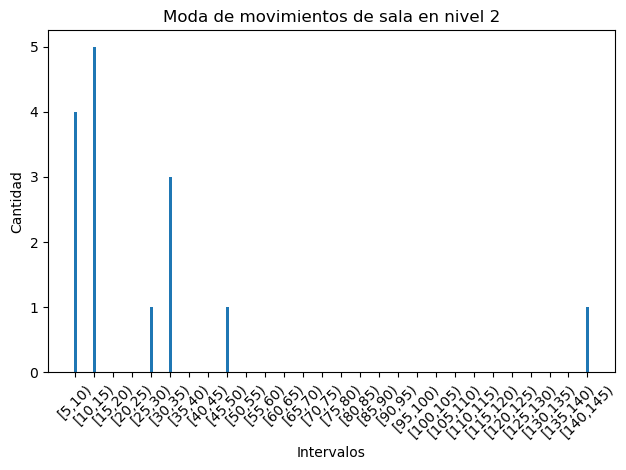

En el nivel 2 la cantidad más repetida/s de movimientos necesarios es/son la/s siguiente/s
[ 10 , 15 )
Repitiendose un total de  5  veces


In [5]:
#Eventos de movimiento de sala
room_moves = groupedEvents.get_group(11)

#Agrupar los movimientos por sesión y nivel
movements = room_moves.groupby(['GameSession', 'Level']).size().reset_index(name='Movements')

#Obtener las sesiones únicas de los eventos de fin
endEventSessions = endEvent_filtered['GameSession'].unique()

#LevelIDs de los eventos completados
completed_levels = endEvent_filtered[endEvent_filtered['LevelEnd'] == 0]['Level'].unique()
#Filtrar los movimientos que pertenecen a una sesión de juego completada
completed_room_moves = room_moves[(room_moves['GameSession'].isin(endEventSessions)) & (room_moves['Level'].isin(completed_levels))]

#Agrupar los movimientos filtrados por sesión y nivel
completed_movements = completed_room_moves.groupby(['GameSession', 'Level']).size().reset_index(name='Movements')

#Level 1
filtered_movements_1 = completed_movements[completed_movements['Level'] == 1.0]
conteos_nivel_1 = {}

#Iterar sobre las filas de filtered_movements_1
for index, fila in filtered_movements_1.iterrows():
    movimientos = fila['Movements']
    #Redondear
    clave=int(movimientos/5)
    clave= clave*5
    if clave in conteos_nivel_1:
        conteos_nivel_1[clave]=conteos_nivel_1[clave]+1
    else:
        conteos_nivel_1[clave]=1

moda = max(conteos_nivel_1, key=lambda k: conteos_nivel_1[k])

#Obtener las claves y valores del diccionario
claves = list(conteos_nivel_1.keys())
valores = list(conteos_nivel_1.values())

#Gráfico 1
plt.bar(claves, valores)
plt.xlabel('Intervalos')
plt.ylabel('Cantidad')
plt.title('Moda de movimientos de sala en nivel 1')
#rotar
plt.xticks(rotation=45)
#Redondear
ubicaciones_x = range(0, max(claves) + 1, 5)
etiquetas_x = [f"[{i},{i+5})" for i in ubicaciones_x]
plt.xticks(ubicaciones_x, etiquetas_x)
plt.yticks(range(int(max(valores)) + 1))
plt.tight_layout()
plt.show()
clavesMax=[]
moda = max(conteos_nivel_1.values())
for i in claves:
    if conteos_nivel_1[i]>=moda:
        clavesMax.append(i)

print("En el nivel 1 la cantidad más repetida/s de movimientos necesarios es/son la/s siguiente/s")
for c in clavesMax:
    print("[",c,",",c+5,")")
print("Repitiendose un total de ", moda," veces")
#Level 2
if 2.0 in completed_levels:
    filtered_movements_2 = completed_movements[completed_movements['Level'] == 2.0]
    conteos_nivel_2 = {}

    for index, fila in filtered_movements_2.iterrows():
        movimientos = fila['Movements']
        
        clave=int(movimientos/5)
        clave=clave*5
        if clave in conteos_nivel_2:
            conteos_nivel_2[clave]=conteos_nivel_2[clave]+1
        else:
            conteos_nivel_2[clave]=1

    claves = list(conteos_nivel_2.keys())
    valores = list(conteos_nivel_2.values())

    if claves:
        plt.bar(claves, valores)
        plt.xlabel('Intervalos')
        plt.ylabel('Cantidad')
        plt.title('Moda de movimientos de sala en nivel 2')

        plt.yticks(range(int(max(valores)) + 1))
        ubicaciones_x = range(0, max(claves) + 1, 5)
        etiquetas_x = [f"[{i},{i+5})" for i in ubicaciones_x]
        #rotar
        plt.xticks(rotation=45)
        plt.xticks(range(min(claves), max(claves) + 1, 5), [f"[{i},{i+5})" for i in range(min(claves), max(claves) + 1, 5)])
        plt.tight_layout()
        plt.show()
        
        clavesMax=[]
        moda = max(conteos_nivel_2.values())
        for i in claves:
            if conteos_nivel_2[i]>=moda:
                clavesMax.append(i)

        print("En el nivel 2 la cantidad más repetida/s de movimientos necesarios es/son la/s siguiente/s")
        for c in clavesMax:
            print("[",c,",",c+5,")")
        print("Repitiendose un total de ", moda," veces")
    else:
        print("No hay datos para mostrar en el nivel 2.")
else:
    print("No hay niveles completados en el nivel 2.")

# Métrica 3: Precisión de golpes a los enemigos
¿El jugador falla significativamente más ataques en el nivel 2 que en el nivel 1?

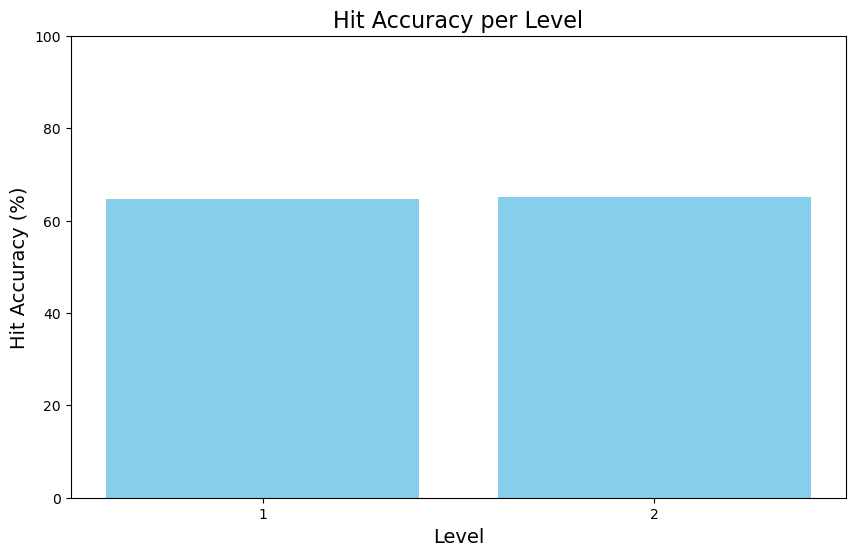

Precisión de golpes a los enemigos:



,Level,Accuracy
0,1,64.71%
1,2,65.00%


La media de la precisión de golpes a enemigos en el nivel 2 es mayor que la del nivel 1 por un 0.29%.


In [6]:

if 8 in groupedEvents.groups:
    attack = groupedEvents.get_group(8)
    enemy_receive = groupedEvents.get_group(9) if 9 in groupedEvents.groups else None
    #display(attack)
    #display(enemy_receive)

    #Se agrupan los ataques realizados y los recibidos por los enemigos y se cuenta el número de cada uno
    attack_count = attack.groupby('Level').size().reset_index(name='Total Attacks')
    
    #Si el grupo 9 existe, contamos los aciertos; de lo contrario, asumimos que son 0
    if enemy_receive is not None:
        hit_count = enemy_receive.groupby('Level').size().reset_index(name='Total Hits')
    else:
        hit_count = pd.DataFrame({'Level': attack_count['Level'], 'Total Hits': 0})
    
    #Agrupar los datos en un único dataframe
    accuracy = pd.merge(attack_count, hit_count, on='Level', how='left')
    accuracy['Total Hits'] = accuracy['Total Hits'].fillna(0)

    #Calcular la precisión de los golpes
    accuracy['Accuracy'] = (accuracy['Total Hits'] / accuracy['Total Attacks']) * 100
    accuracy['Level'] = accuracy['Level'].astype(int)

    plt.figure(figsize=(10, 6))
    plt.bar(accuracy['Level'], accuracy['Accuracy'], color='skyblue')
    plt.xlabel('Level', fontsize=14)
    plt.ylabel('Hit Accuracy (%)', fontsize=14)
    plt.title('Hit Accuracy per Level', fontsize=16)
    plt.xticks(accuracy['Level'])
    plt.ylim(0, 100)
    plt.show()
    
    accuracy['Accuracy'] = accuracy['Accuracy'].apply(lambda x: f"{x:.2f}%")
    print("Precisión de golpes a los enemigos:\n")
    display(accuracy[['Level', 'Accuracy']])
    accuracy[['Level', 'Accuracy']].to_string(index=False)
    #Separar por niveles
    level_1_accuracy = accuracy[accuracy['Level'] == 1]['Accuracy'].values[0]
    level_2_accuracy = accuracy[accuracy['Level'] == 2]['Accuracy'].values[0]
    #Quitar '%'
    level_1_accuracy = float(level_1_accuracy.replace('%', ''))
    level_2_accuracy = float(level_2_accuracy.replace('%', ''))

    if level_1_accuracy > level_2_accuracy:
        difference_percentage = level_1_accuracy - level_2_accuracy
        print(f"La media de la precisión de golpes a enemigos en el nivel 1 es mayor que la del nivel 2 por un {difference_percentage:.2f}%.")
    elif level_1_accuracy < level_2_accuracy:
        difference_percentage = level_2_accuracy - level_1_accuracy
        print(f"La media de la precisión de golpes a enemigos en el nivel 2 es mayor que la del nivel 1 por un {difference_percentage:.2f}%.")
    else:
        print("La media de la precisión de golpes a enemigos en el nivel 1 es igual a la del nivel 2.")
else:
    print("Nunca se han llevado a cabo ataques.")


# Métrica 4: Impactos de los elementos dañinos
¿Es coherente la variación de impactos provocados por cada elemento dañino a lo largo de los dos niveles?


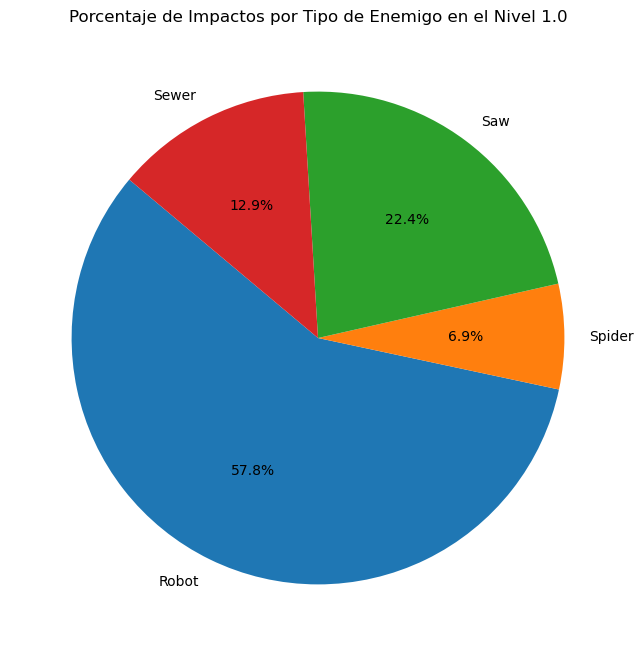

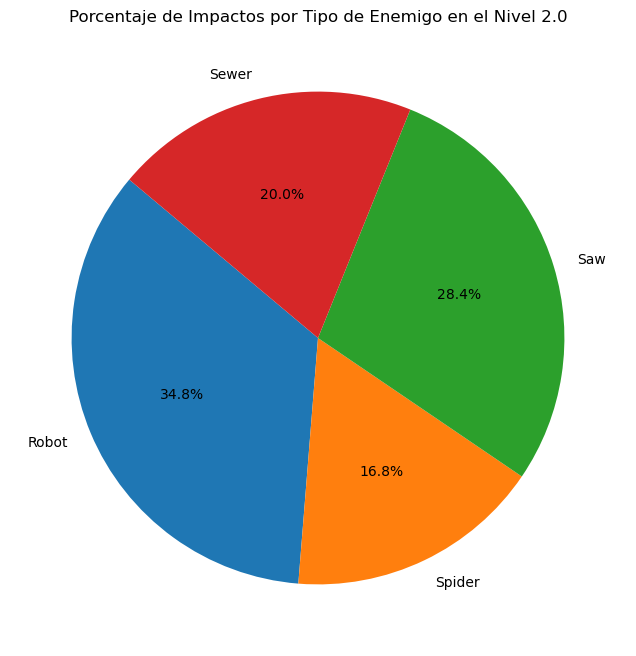

In [7]:
player_receive = groupedEvents.get_group(10)

#Se agrupan los impactos por sesión y tipo de enemigo y se cuenta el número de cada una
impact_count = player_receive.groupby(['Level', 'EnemyType']).size().reset_index(name='Impacts')

#Impactos totales por sesión
total_impact_count = player_receive.groupby('Level').size().reset_index(name='Total Impacts')

#Agrupar los datos en un único dataframe
impact_count = impact_count.merge(total_impact_count, on='Level', how='left')

#Calcular porcentaje de impactos provocados por cada tipo de enemigo
impact_count['Accuracy'] = (impact_count['Impacts'] / impact_count['Total Impacts']) * 100

#Mapeo de nombres de enemigos
enemy_names = {
    0: "Robot",
    1: "Spider",
    2: "Saw",
    3: "Sewer"
}
impact_count['EnemyType'] = impact_count['EnemyType'].map(enemy_names)

levels = impact_count['Level'].unique()

for level in levels:
    data_level = impact_count[impact_count['Level'] == level]
    
    plt.figure(figsize=(8, 8))
    plt.pie(data_level['Accuracy'], labels=data_level['EnemyType'].astype(str), autopct='%1.1f%%', startangle=140)
    plt.title(f'Porcentaje de Impactos por Tipo de Enemigo en el Nivel {level}')
    plt.show()
    
impact_count['Accuracy'].fillna(0, inplace=True)
impact_count['AccuracyText'] = impact_count['Accuracy'].apply(lambda x: f"{x:.3f}%")
